In [4]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np 
import torchvision.transforms as transforms
import copy
import librosa

## Load and analyze Files

In [5]:
def read_audio_spectum(filename, N_FFT=2048):
        x, fs = librosa.load(filename, duration=58.04) # Duration=58.05 so as to make sizes convenient
        S = librosa.stft(x, N_FFT)
        p = np.angle(S)
        S = np.log1p(np.abs(S))  
        return S, fs

In [6]:
content_file = "inputs/gtzan_hiphop_10s_style.mp3"
style_file = "inputs/elevator_music_10s_content.mp3"

In [7]:
style_audio, fs = read_audio_spectum(style_file)
content_audio, fs = read_audio_spectum(content_file)

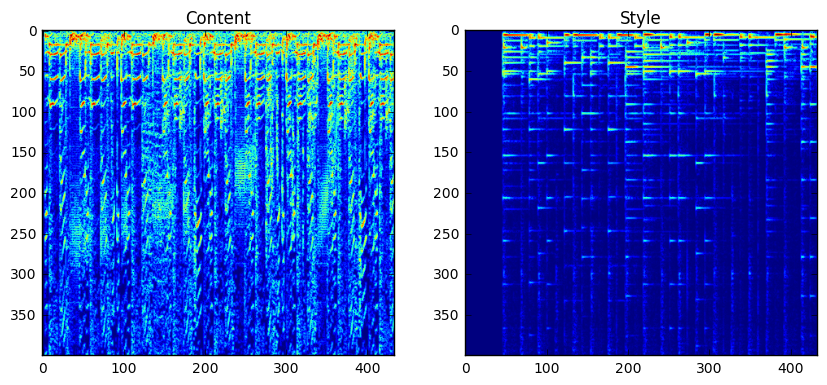

In [8]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Content')
plt.imshow(content_audio[:400,:])
plt.subplot(1, 2, 2)
plt.title('Style')
plt.imshow(style_audio[:400,:])
plt.show()

In [6]:
num_samples_style=style_audio.shape[1]    
num_samples_content=content_audio.shape[1]
style_audio = style_audio.reshape([1,1025,num_samples_style])
content_audio = content_audio.reshape([1,1025,num_samples_content])

if torch.cuda.is_available():
    style_float = Variable((torch.from_numpy(style_audio)).cuda())
    content_float = Variable((torch.from_numpy(content_audio)).cuda())    
else:
    style_float = Variable(torch.from_numpy(style_audio))
    content_float = Variable(torch.from_numpy(content_audio))


## Style Transfer Architecture using a Pytorch Module Approach

In [7]:
class CNNModel(nn.Module):
        def __init__(self):
            super(CNNModel, self).__init__()
            self.cnn1 = nn.Conv1d(in_channels=1025, out_channels=4096, kernel_size=3, stride=1, padding=1)
            self.nl1 = nn.ReLU()
        
        def forward(self, x):
            out = self.cnn1(x)
            out = out.contiguous().view(out.size(0)* out.size(1)*out.size(2),-1)
            out = self.nl1(out)
            return out

In [8]:
class GramMatrix(nn.Module):
    def forward(self, input):
        a, b, c = input.size()  # a=batch size(=1)
        features = input.view(a * b, c)  
        G = torch.mm(features, features.t())  # compute the gram product
        # "normalize" gramm matrix
        return G.div(a * b * c)

In [9]:
class StyleLoss(nn.Module):
    def __init__(self, target, weight):
        super(StyleLoss, self).__init__()
        self.target = target.detach() * weight
        self.weight = weight
        self.gram = GramMatrix()
        self.criterion = nn.MSELoss()

    def forward(self, input):
        self.output = input.clone()
        self.G = self.gram(input)
        self.G.mul_(self.weight)
        self.loss = self.criterion(self.G, self.target)
        return self.output

    def backward(self,retain_graph=True):
        self.loss.backward(retain_graph=retain_graph)
        return self.loss

In [10]:
#gives a model with style loss, we backprop over this new model
def get_style_model_and_losses(cnn, style_float,style_weight=3000, style_layers=['conv_1']): #STYLE WEIGHT
        
        cnn = copy.deepcopy(cnn)
        style_losses = []
        model = nn.Sequential()  # the new Sequential module network
        gram = GramMatrix()  # we need a gram module in order to compute style targets
        if torch.cuda.is_available():
            model = model.cuda()
            gram = gram.cuda()

        name = 'conv_1'
        model.add_module(name, cnn.cnn1)
        if name in style_layers:
            target_feature = model(style_float).clone()
            target_feature_gram = gram(target_feature)
            style_loss = StyleLoss(target_feature_gram, style_weight)
            model.add_module("style_loss_1", style_loss)
            style_losses.append(style_loss)
            
        return model, style_losses   
def get_input_param_optimizer(input_float):
    
        input_param = nn.Parameter(input_float.data)
        optimizer = optim.Adam([input_param], lr=learning_rate_initial, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)
        return input_param, optimizer


In [11]:
def run_style_transfer(cnn, style_float, input_float, num_steps=300): #STYLE WEIGHT, NUM_STEPS
        print('Building the style transfer model..')
        model, style_losses= get_style_model_and_losses(cnn, style_float)
        input_param, optimizer = get_input_param_optimizer(input_float)
        print('Optimizing..')
        run = [0]

        while run[0] <= num_steps:
            def closure():
                # correct the values of updated input image
                input_param.data.clamp_(0, 1)

                optimizer.zero_grad()
                model(input_param)
                style_score = 0

                for sl in style_losses:
                    #print('sl is ',sl,' style loss is ',style_score)
                    style_score += sl.backward()

                run[0] += 1
                if run[0] % 100 == 0:
                    print("run {}:".format(run))
                    print('Style Loss : {:8f}'.format(style_score.data[0])) #CHANGE 4->8 
                    print()

                return style_score

            optimizer.step(closure)
        input_param.data.clamp_(0, 1)
        return input_param.data

## Begin Style Transfer Process

In [12]:
cnn = CNNModel()
input_float = content_float.clone()
learning_rate_initial = 0.03

In [ ]:
output = run_style_transfer(cnn, style_float, input_float)

## Convert back to audio and write to file

In [ ]:
output = output.squeeze(0)
output = output.numpy()
#print(output.shape)
#output = output.resize([1025,2500])

N_FFT=2048
a = np.zeros_like(output)
a = np.exp(output) - 1

# This code is supposed to do phase reconstruction
p = 2 * np.pi * np.random.random_sample(a.shape) - np.pi
for i in range(500):
    S = a * np.exp(1j*p)
    x = librosa.istft(S)
    p = np.angle(librosa.stft(x, N_FFT))
output_file = 'outputs/hiphopElevator.wav'
librosa.output.write_wav(output_file, x, style_sr)

## Read in output file and plot spectrogram

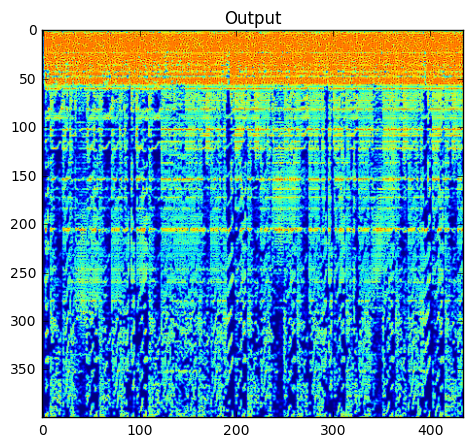

In [15]:
output_file = 'outputs/hiphopElevator.wav'
output_audio, fs = read_audio_spectum(output_file)
plt.figure(figsize=(10, 5))
plt.title('Output')
plt.imshow(output_audio[:400,:])
plt.show()